# Imports

## For plots

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

## Imports from standard packages

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.io import fits

## Local imports

In [3]:
from extract.overlap import TrpzOverlap

# Read tikhonov tests

In [13]:
from run_tikho_test import TikhoTest

ModuleNotFoundError: No module named 'overlap'

<IPython.core.display.Javascript object>


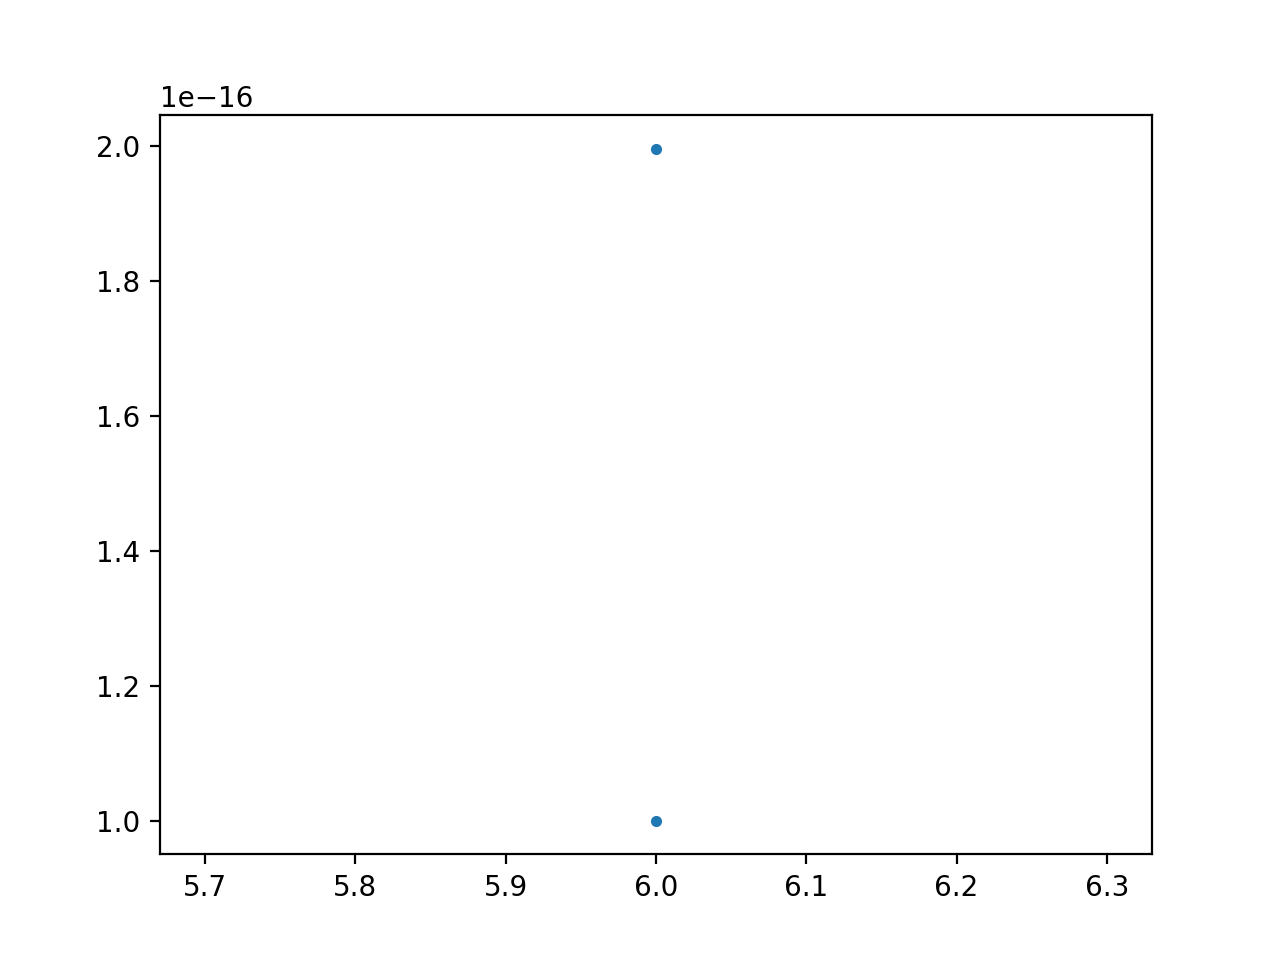

In [29]:
# Parameters to test
n_os_list = [6]
c_thresh_list = [1e-3]
t_mat_n_os_list = [2]
i_ord_list = [0, 1]
file_root = 'sinus_noisy'

# Init output
shape = (len(i_ord_list),
         len(n_os_list),
         len(c_thresh_list),
         len(t_mat_n_os_list))
best_fac = np.ones(shape) * np.nan
# Iterate on grid oversampling
for i_os, n_os in enumerate(n_os_list):
    # Iterate on convolution kernel wings threshold
    for i_c, c_thresh in enumerate(c_thresh_list):
        # Iterate on resolution of the tikhonov matrix
        for i_t_mat, t_mat_n_os in enumerate(t_mat_n_os_list):
            test = TikhoTest.read(n_os, c_thresh, t_mat_n_os,
                                  file_root=file_root)
            for i_ord in i_ord_list:
                # Save factor with minimum error
                err = test.get_extract_err(i_ord=i_ord)
                i_min = np.argmin(err)
                index = i_ord, i_os, i_c, i_t_mat
                best_fac[index] = test.results['factors'][i_min]
                
fig, ax = plt.subplots(1, 1,)
for i_c, c_thresh in enumerate(c_thresh_list):
    for i_t_mat, t_mat_n_os in enumerate(t_mat_n_os_list):
        line = ax.plot(n_os_list, best_fac[0, :, i_c, i_t_mat],'.-')
        color = line[-1].get_color()
        ax.plot(n_os_list, best_fac[1, :, i_c, i_t_mat], '--.', color=color)

<IPython.core.display.Javascript object>


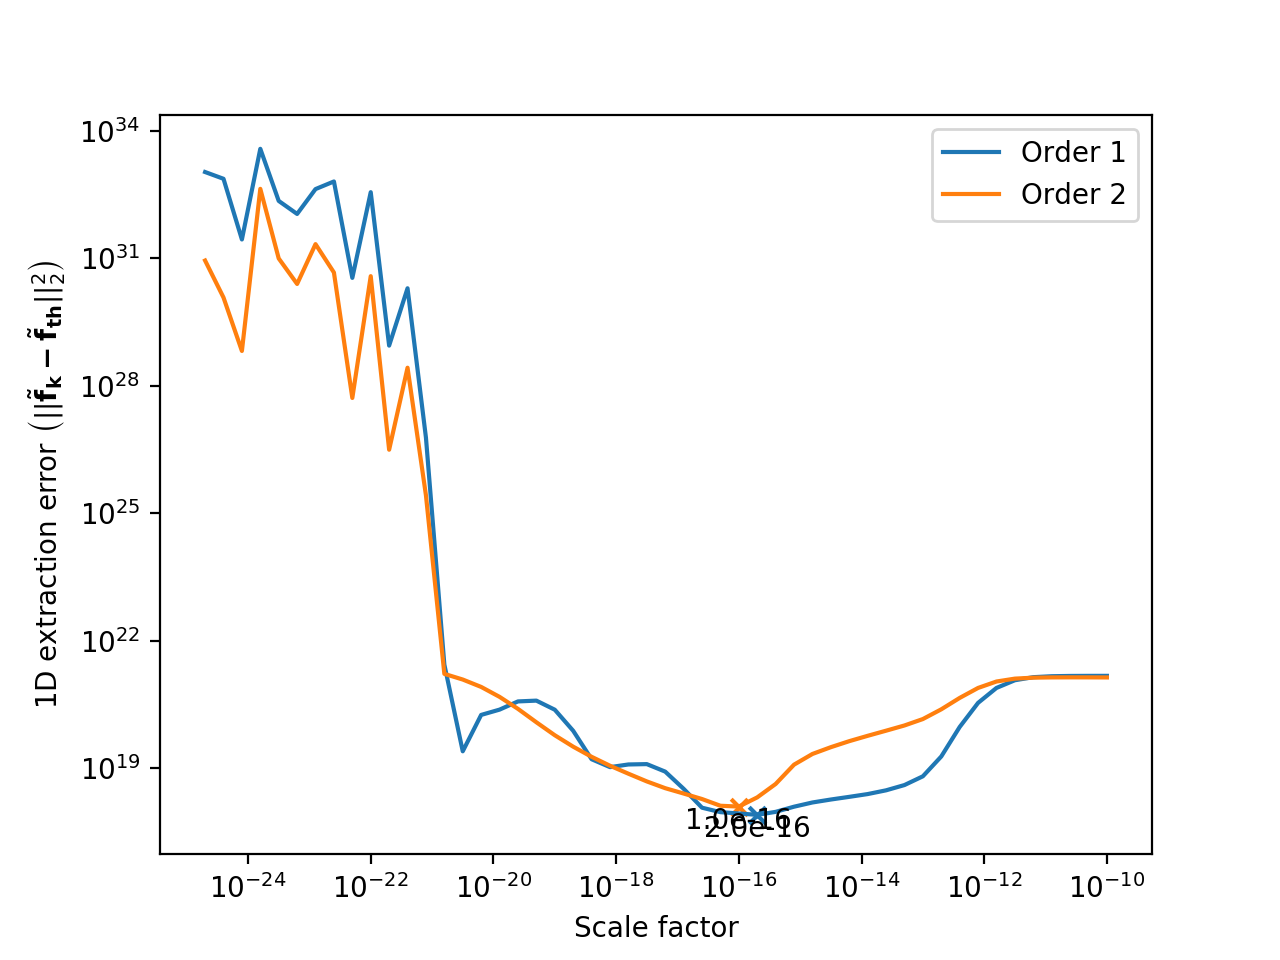

In [17]:
fig, ax = test.plot_extract_err(label='Order 1')
test.plot_extract_err(ax=ax, i_ord=1, label='Order 2')
plt.legend()


# Run tests

### Read ref files

In [4]:
# Read relevant files
wv_1 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/wavelengths_m2.fits")[0].data
P1 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/spat_profile_m1.fits")[0].data.squeeze()
P2 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/spat_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

# Remove the tilt from wv maps
wv_1 = np.tile(wv_1[50,:], (256, 1))
wv_2 = np.tile(wv_2[50,:], (256, 1))

### Setup for simulation

### Wavelength grid

In [5]:
# lam_simu = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=15)

### Initiate a simulation.

In [6]:
# Choose a small threshold for the spatial profile cut
# (less than for a normal extraction)
simu = TrpzOverlap([P1,P2], [wv_1,wv_2], n_os=15, thresh=1e-8, c_kwargs={'thresh':1e-6})

### Use PHOENIX spectrum

### Read stellar spectrum

In [7]:
path = "/Users/antoinedb/Documents/Doctorat/SOSS/"
file = "Z-0.0-lte02300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-n_os-15.npz"
spec_file = np.load(path+file)

In [8]:
wv, flux = spec_file["wave"], spec_file["flux"]
flux_interp = interp1d(wv, flux, kind="cubic", bounds_error=False, fill_value=0.)

### Inject spectrum

In [9]:
# Generate flux to inject
flux = flux_interp(simu.lam_grid)
# Multiplication by a fudge factor to get
# a realistic number of counts on the detector
# flux *= 1e12
# flux *= 1e9
flux /= 1e3

# Inject order 1 and 2 separately (we don't want any contamination here)
data1 = simu.rebuild(flux, orders=[0])
data2 = simu.rebuild(flux, orders=[1])

<IPython.core.display.Javascript object>


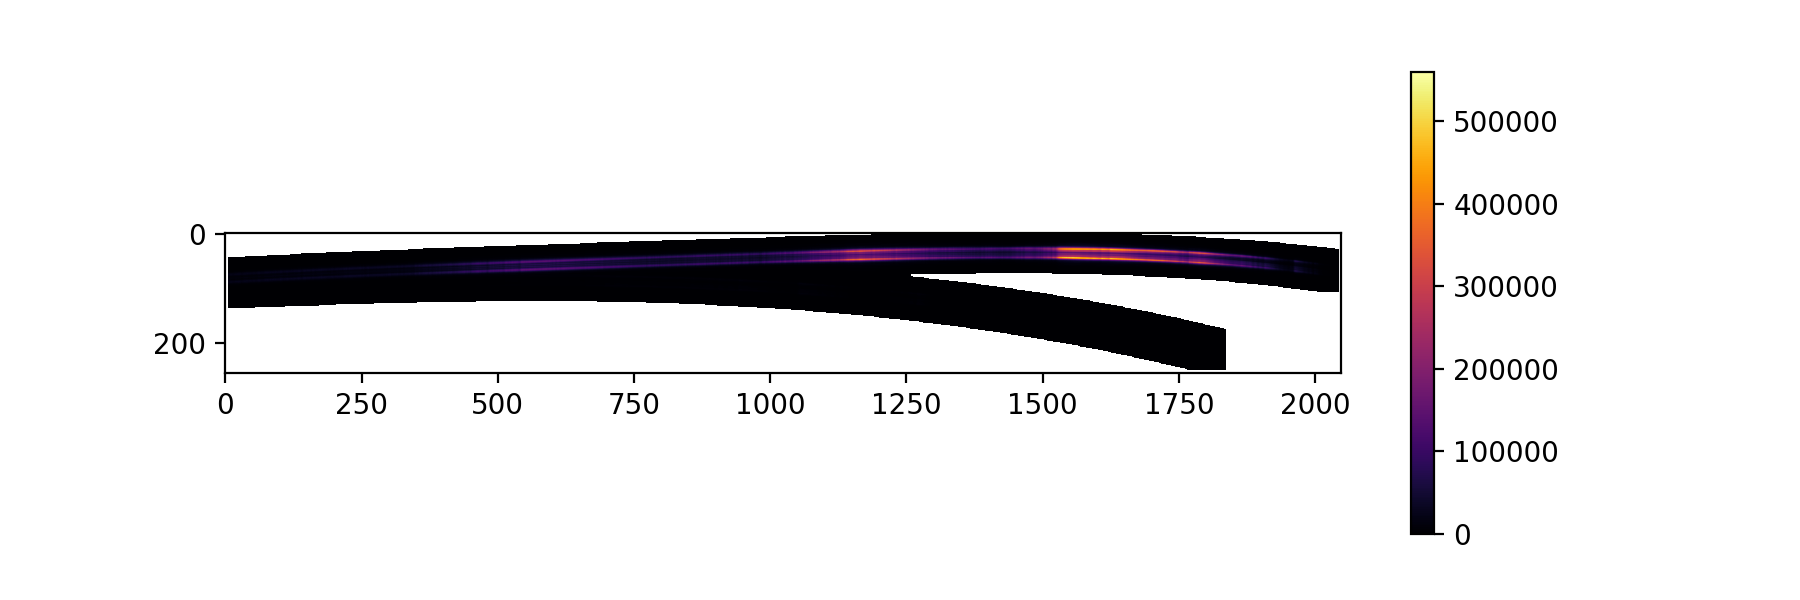

In [10]:
plt.imshow(data1 + data2)
plt.colorbar()

## Test on pixels
Test sensitivity to the choice of tikhonov factor when integrated on pixel

### Extraction with Tikhonov

In [ ]:
# Parameters for extraction
n_os = 4
c_thresh = 1e-5
t_mat_n_os = 2

### Extract

In [ ]:
# lam_grid = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=n_os)
extra = TrpzOverlap([P1, P2], [wv_1, wv_2], scidata=data1 + data2,
                    n_os=n_os, thresh=1e-5,
                    c_kwargs={'thresh': c_thresh})

In [16]:
factors = 10.**(-1*np.arange(11, 17, 0.3))
extra.get_tikho_tests(factors)

Testing factors...
20/20


{'factors': array([1.00000000e-11, 5.01187234e-12, 2.51188643e-12, 1.25892541e-12,
        6.30957344e-13, 3.16227766e-13, 1.58489319e-13, 7.94328235e-14,
        3.98107171e-14, 1.99526231e-14, 1.00000000e-14, 5.01187234e-15,
        2.51188643e-15, 1.25892541e-15, 6.30957344e-16, 3.16227766e-16,
        1.58489319e-16, 7.94328235e-17, 3.98107171e-17, 1.99526231e-17]),
 'solution': array([[ 1.58313669e+07,  1.58313670e+07,  1.58313670e+07, ...,
          7.50137488e+08,  6.37187252e+08,  4.54061005e+08],
        [ 1.61372287e+07,  1.61372289e+07,  1.61372289e+07, ...,
          7.22605469e+08,  6.13796853e+08,  4.37393027e+08],
        [ 1.31938357e+07,  1.31938375e+07,  1.31938372e+07, ...,
          6.95938809e+08,  5.91141562e+08,  4.21248887e+08],
        ...,
        [ 2.05764391e+07,  2.05718857e+07,  2.05612104e+07, ...,
          7.32047674e+09,  6.21889322e+09,  4.43182675e+09],
        [ 2.02744170e+07,  2.02679919e+07,  2.02548058e+07, ...,
         -9.27422892e+09, -7.8808

In [17]:
from analysis import TikhoAnalysis

In [18]:
# extra.tikho.test["grid"] = extra.lam_grid[extra.i_grid]
analysis = TikhoAnalysis(n_os, c_thresh, t_mat_n_os, results=extra.tikho.test)

<IPython.core.display.Javascript object>


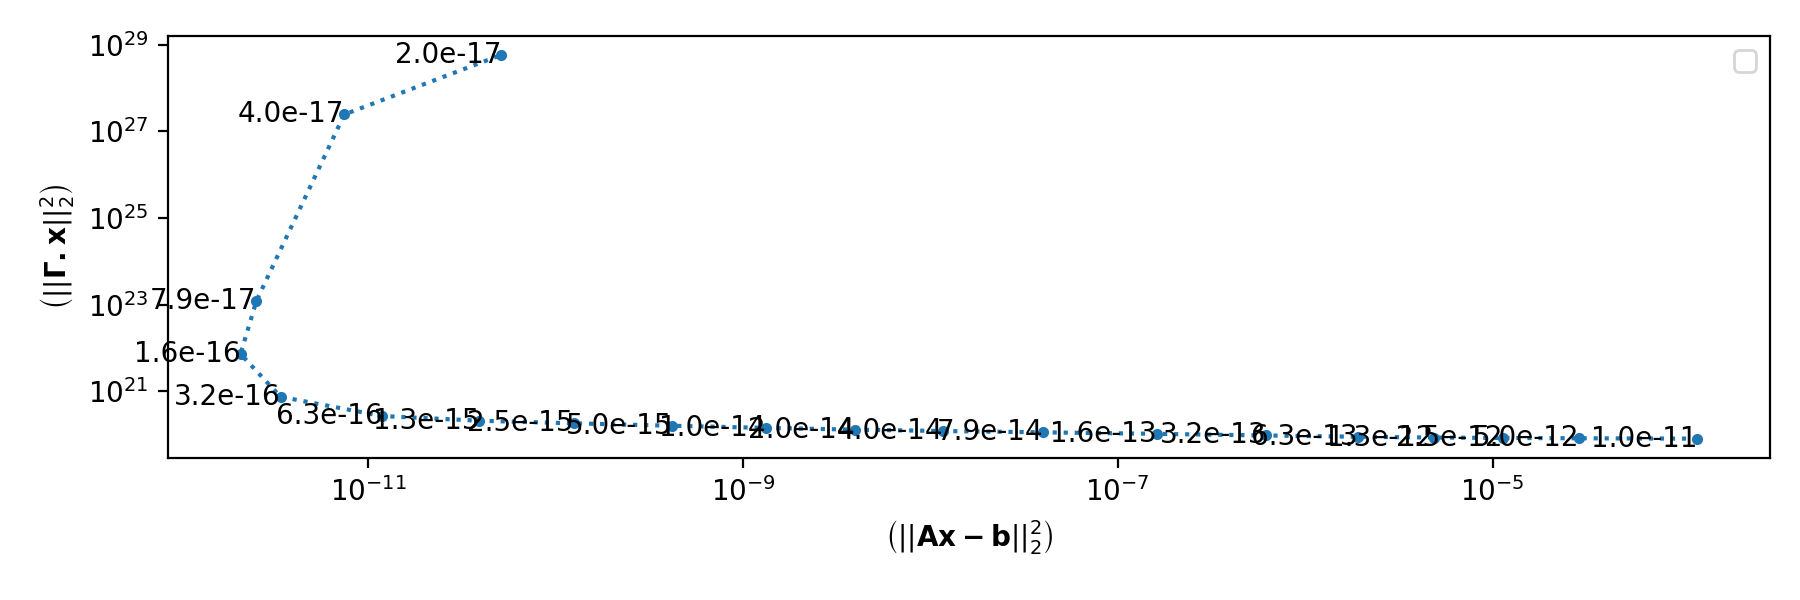

No handles with labels found to put in legend.


In [19]:
analysis.l_plot()
# plt.yscale("linear")
plt.tight_layout()

<IPython.core.display.Javascript object>


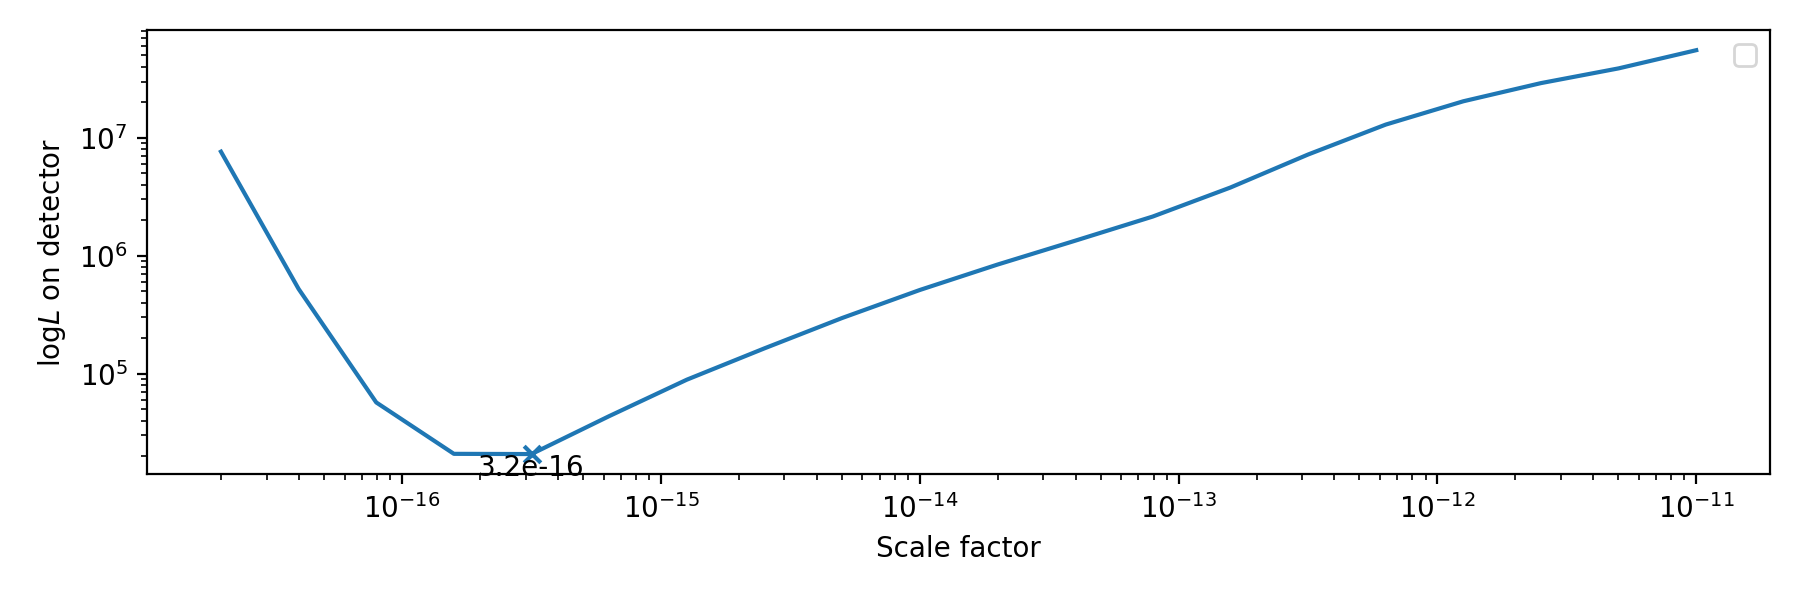

No handles with labels found to put in legend.


In [106]:
fig, ax = analysis.error_plot(key="-logl")
ax.set_ylabel(r'$\log{L}$ on detector')
plt.tight_layout()

In [22]:
pix_chi2 = []
for i_ord in range(extra.n_ord):
    pix_chi2.append(analysis.get_bin_error(simu, f_k=flux, i_ord=i_ord)[0])

<IPython.core.display.Javascript object>


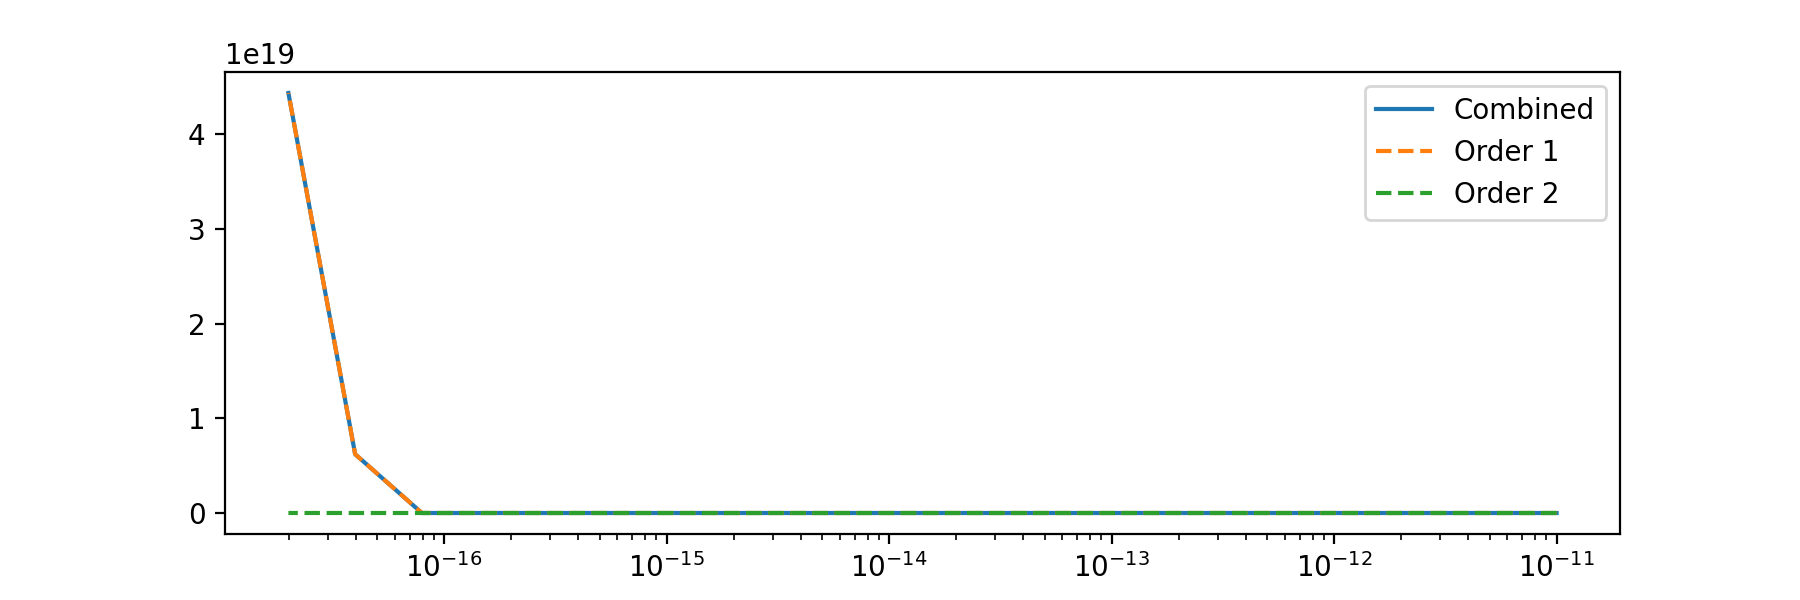

In [23]:
plt.semilogx(analysis.results['factors'], pix_chi2[0] + pix_chi2[1], label="Combined")
plt.semilogx(analysis.results['factors'], pix_chi2[0], "--", label="Order 1")
plt.semilogx(analysis.results['factors'], pix_chi2[1], "--", label="Order 2")
plt.legend()

## test different levels of nooise

In [ ]:
from simulation_utils import add_noise

In [149]:
# Generate flux to inject
flux_list = flux_interp(lam_simu)[None, :] * 10.**-np.arange(5, 2, -1)[:,None]
# Parameters for extraction
n_os = 4
c_thresh = 1e-5
t_mat_n_os = 2
lam_grid = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=n_os)
factors = 10.**(-1*np.arange(11, 22, 0.3))

analysis_list = []
for flux in flux_list:
    
    data_noisy = add_noise(simu.rebuild(flux))
    sig = np.sqrt(data_noisy + 20.**2)  # Map of expected noise
    
    extra = TrpzOverlap([P1, P2], [wv_1, wv_2], scidata=data_noisy,
                        lam_grid=lam_grid, thresh=1e-5, sig=sig,
                        c_kwargs={'thresh': c_thresh})
    
    tests = extra.get_tikho_tests(factors)
    i_grid = tests["i_grid"]
    extra = TrpzOverlap([P1, P2], [wv_1, wv_2], scidata=data_noisy,
                        lam_grid=lam_grid[i_grid], thresh=1e-5, sig=sig,
                        c_kwargs={'thresh': c_thresh})
    tests = TikhoAnalysis(n_os, c_thresh, t_mat_n_os, results=tests, extra=extra)
    analysis_list.append(tests)
    

Testing factors...
37/37
Testing factors...
37/37
Testing factors...
37/37


In [108]:
# def selfgrid_from_map(self, i_ord=0):
#     """
#     Return the wavelength grid associated to a given order
#     """
#     gargs = ("lam_list", "p_list")
#     wv_map, psf = self.getattrs(*gargs, n=i_ord)
#     return _grid_from_map(wv_map, psf, out_col=True)
    
    
# def selfestim_noise(self, i_ord=0, sig=None, mask=None):
#     """
#     Relative noise estimate over columns
#     """
    
#     if sig is None:
#         sig = self.sig
    
#     if mask is None:
#         mask = self.mask_ord[i_ord]
        
    
    
#     noise = np.ma.array(sig, mask=mask)
#     # RMS over columns
#     noise = np.sqrt((noise**2).sum(axis=0))
#     # Relative
#     noise /= np.ma.array(self.data, mask=mask).sum(axis=0)
#     # Convert to array with nans
#     noise = noise.filled(fill_value=np.nan)
    
#     # Get associated wavelengths
#     lam_grid, i_col = selfgrid_from_map(self, i_ord)
    
#     # Return sorted according to wavelenghts
#     return lam_grid, noise[i_col]

In [213]:
def get_bin_sln(self, factor=None, index=None, results=None,
                  extra=None, **kwargs):

    # Manage inputs
    if extra is None:
        extra = self.get_extraction()

    if results is None:
        results = self.results
        
    if index is None:
        if factor is None:
            message = 'At least `factor` or `index` must be specified.'
            raise ValueError(message)
        else:
            index = np.argmin(np.abs(results['factors'] - factor))

    # Get pre-computed solutions
    f_k = results["solution"][index]

    # Get theoretical integrated flux
    return extra.bin_to_pixel(f_k=f_k, **kwargs)

def get_bin_error(self, simu, factor=None, index=None, results=None,
                  extra=None, sigma=True, err_type="absolute", **kwargs):

    # Manage inputs
    if extra is None:
        extra = self.get_extraction()

    if results is None:
        results = self.results
        
    if index is None:
        if factor is None:
            message = 'At least `factor` or `index` must be specified.'
            raise ValueError(message)
        else:
            index = np.argmin(np.abs(results['factors'] - factor))

    # Get pre-computed solutions
    f_k_list = results["solution"]

    # Get theoretical integrated flux
    grid_pix, f_bin_th = simu.bin_to_pixel(**kwargs)
    # Use `grid_pix` if not in kwargs
    if not "grid_pix" in kwargs:
        kwargs["grid_pix"] = grid_pix

    # Get error estimate on pixel grid
    if sigma is False:
        sigma = np.ones_like(kwargs["grid_pix"])
    elif sigma is True:
        # Use default estimate of noise
        x, y = self.estim_noise(i_ord=kwargs["i_ord"])
        noise_fct = interp1d(x, y, kind="linear", bounds_error=False)
        # It's the relative noise so convert to absolute
        sigma = noise_fct(grid_pix) * f_bin_th

    # Compute each chi2 on pixels
    kwargs["f_k"] = f_k_list[index]
    _, f_bin = extra.bin_to_pixel(**kwargs)
    error = (f_bin - f_bin_th) / sigma

    return grid_pix, error

def get_bin_chi2(self, simu, results=None,
                  extra=None, sigma=True, err_type="absolute", **kwargs):

    # Manage inputs
    if extra is None:
        extra = self.get_extraction()

    if results is None:
        results = self.results

    # Get pre-computed solutions
    f_k_list = results["solution"]

    # Get theoretical integrated flux
    grid_pix, f_bin_th = simu.bin_to_pixel(**kwargs)
    # Use `grid_pix` if not in kwargs
    if not "grid_pix" in kwargs:
        kwargs["grid_pix"] = grid_pix

    # Get error estimate on pixel grid
    if sigma is False:
        sigma = np.ones_like(kwargs["grid_pix"])
    elif sigma is True:
        # Use default estimate of noise
        x, y = self.estim_noise(kwargs["i_ord"])
        noise_fct = interp1d(x, y, kind="linear", bounds_error=False)
        # It's the relative noise so convert to absolute
        sigma = noise_fct(grid_pix) * f_bin_th

    # Compute each chi2 on pixels
    chi2_list = []
    for f_k in f_k_list:
        kwargs["f_k"] = f_k
        _, f_bin = extra.bin_to_pixel(**kwargs)
        chi2 = np.nansum(((f_bin - f_bin_th) / sigma)**2)
        chi2_list.append(chi2)

    return np.array(chi2_list), len(grid_pix)

def get_bin_mean_err(self, simu, results=None, **kwargs):
    
    if results is None:
        results = self.results
        
    kwargs["results"] = results
    
    # Compute each mean err on pixels
    mean_err, std_err = [], []
    for index, fac in enumerate(results["factors"]):
        grid_pix, err = get_bin_error(self, simu, index=index, **kwargs)
        mean_err.append(np.nanmean(err))
        std_err.append(np.nanstd(err))
        
    return mean_err, std_err

In [151]:
signal = 10.**-np.arange(5, 2, -1)

In [1]:
fig, ax = plt.subplots(2, 1, sharex=True)

for tests, flux, label in zip(analysis_list, flux_list, signal):
    for i_ord in range(extra.n_ord):
        x, y = get_bin_sln(tests, factor=1e-17, i_ord=i_ord)
        ax[i_ord].plot(x, y, label=label)
        # Flux th
        _, y = simu.bin_to_pixel(f_k=flux, grid_pix=x, i_ord=i_ord)
        ax[i_ord].plot(x, y, label=f"{label} th")
    
plt.legend()

NameError: name 'plt' is not defined

<IPython.core.display.Javascript object>


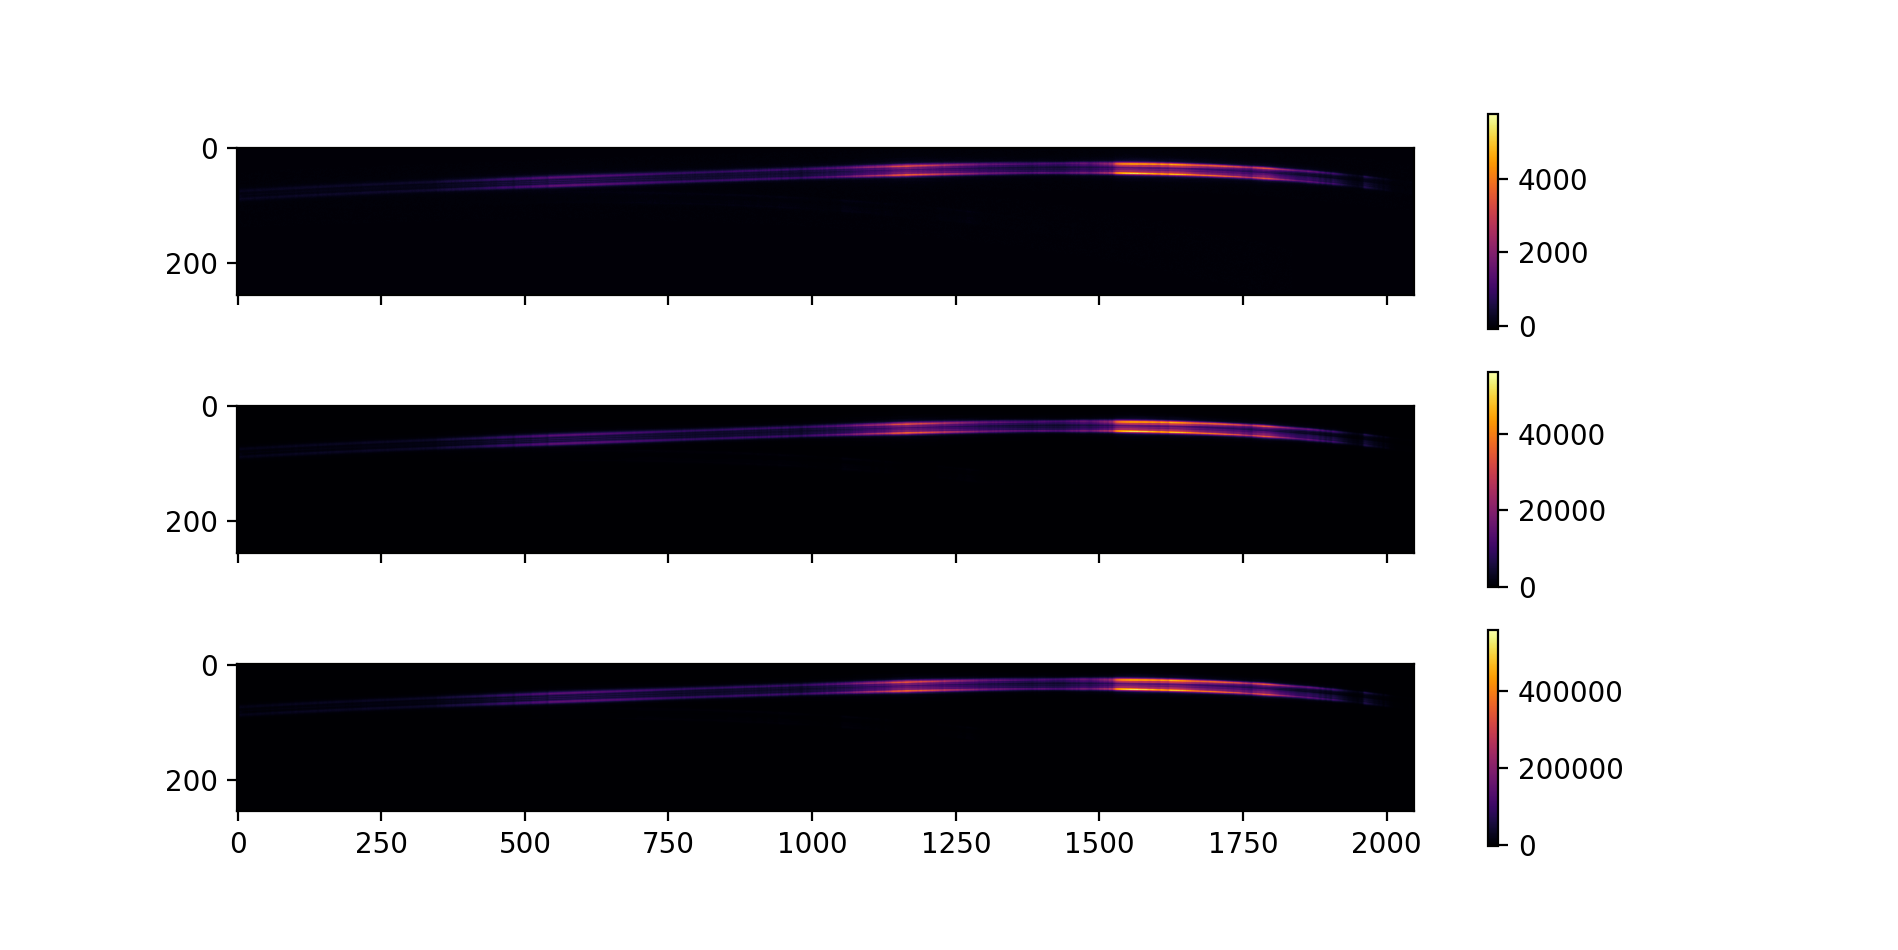

In [331]:
fig, ax = plt.subplots(3,1, sharex=True)
for i_test in range(3):
    im = ax[i_test].imshow(analysis_list[i_test].extra.data)
    plt.colorbar(im, ax=ax[i_test])

<IPython.core.display.Javascript object>


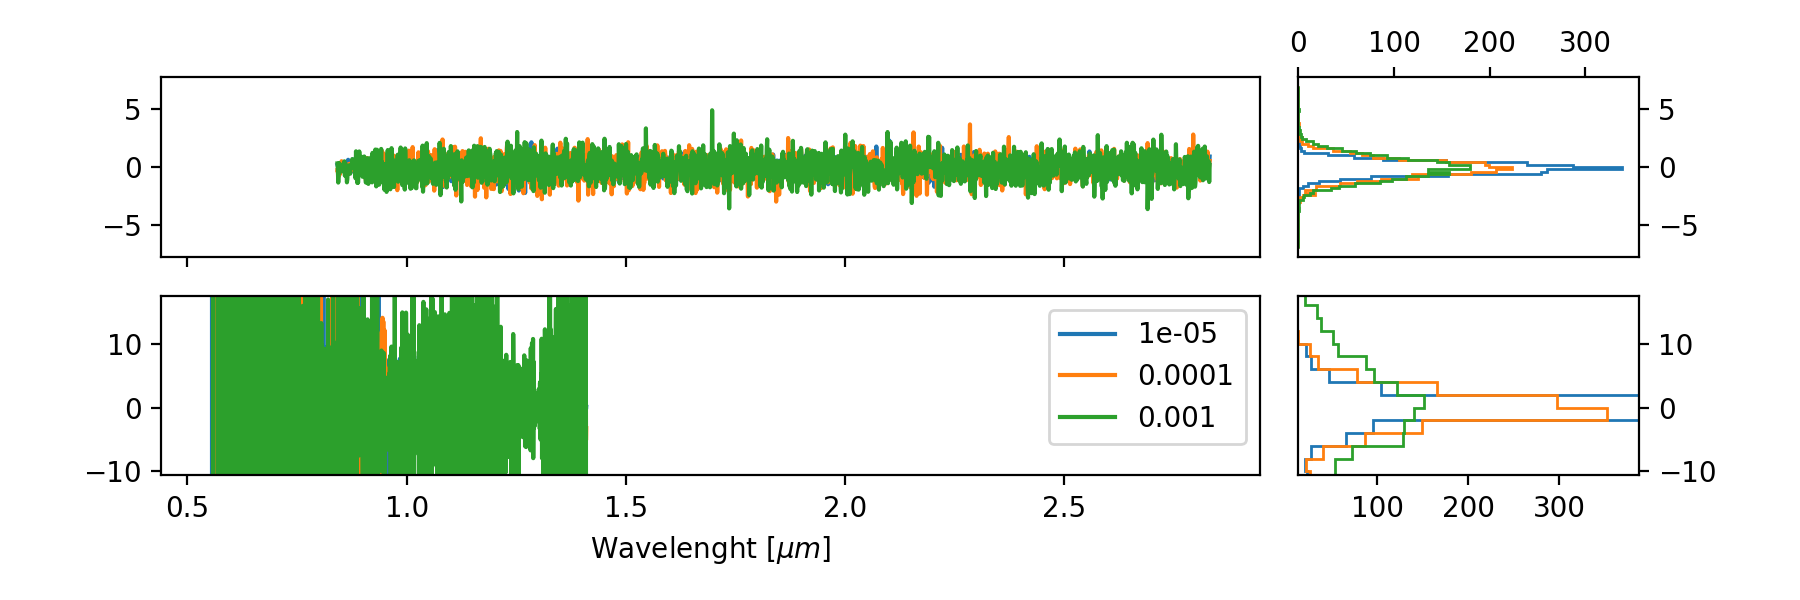

0.5256084286326895
4210.048486690834
0.8291206764685568
3151.011890361042
0.9760461948393497
1140.7087969783952


In [317]:
fig = plt.figure()

ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=3)
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=3, sharex=ax2)
ax3 = plt.subplot2grid((2, 4), (0, 3), sharey=ax1)
ax4 = plt.subplot2grid((2, 4), (1, 3), sharey=ax2)

# ax1.set_xticks([])
ax3.xaxis.tick_top()
ax = np.array([[ax1, ax3], [ax2, ax4]])
[ax[i, 1].yaxis.tick_right() for i in range(2)]

bin_lim = [np.arange(-7, 7.2, 0.2), np.arange(-30, 30.2, 2)]
for tests, flux, label in zip(analysis_list, flux_list, signal):
    pix_chi2 = []
    n_bin_tot = 0
    for i_ord in range(extra.n_ord):
        x, y = get_bin_error(tests, simu, factor=1e-16, f_k=flux, i_ord=i_ord)
        print(np.nanstd(y))
        ax[i_ord, 0].plot(x, y, label=label)
        ax[i_ord, 1].hist(y, bins=bin_lim[i_ord], orientation="horizontal", histtype="step")
    
ax[1,0].legend()
ax[0,0].tick_params(labelbottom=False)
ax[1,0].set_xlabel(r"Wavelenght [$\mu m$]")
plt.tight_layout()

<IPython.core.display.Javascript object>


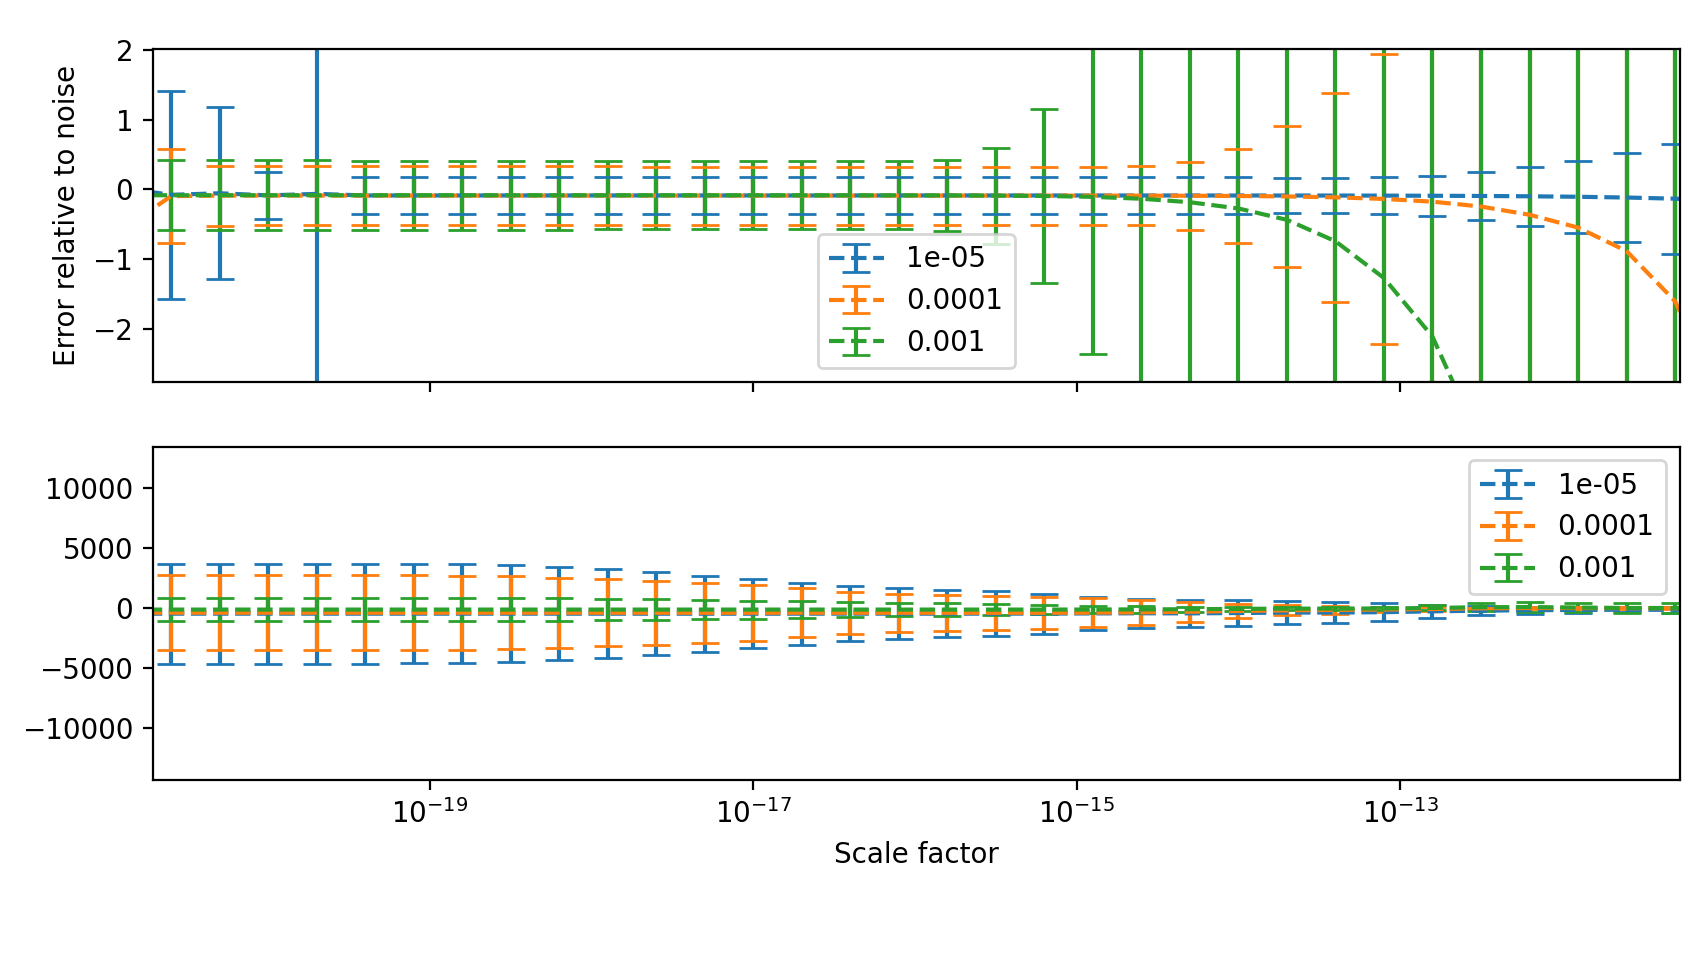

In [247]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_xscale("log")

for tests, flux, label in zip(analysis_list, flux_list, signal):
    for i_ord in range(extra.n_ord):
        err, d_err = get_bin_mean_err(tests, simu, f_k=flux, i_ord=i_ord)
#         ax[i_ord].semilogx(tests.results['factors'], err, "--", label=label)
        ax[i_ord].errorbar(tests.results['factors'], err, yerr=np.array(d_err)/2, fmt="--", capsize=5., label=label)
    
ax[0].legend()
ax[1].legend()
plt.xlabel("Scale factor")
plt.tight_layout()

In [256]:
ax[0].set_ylabel("Error relative to noise")

Text(36.513888888888886, 0.5, 'Error relative to noise')

In [254]:
plt.xlabel("Scale factor")
plt.tight_layout()

<IPython.core.display.Javascript object>


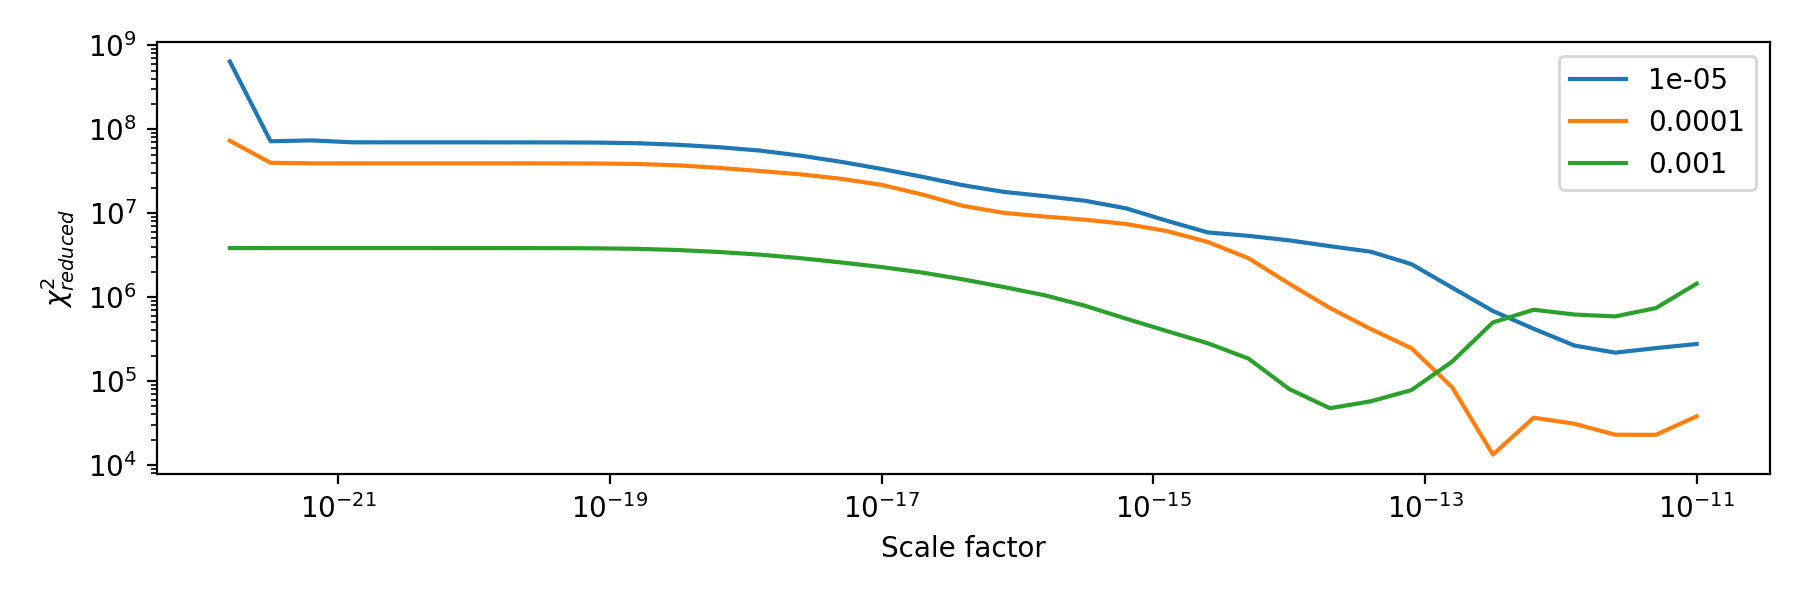

In [280]:
for tests, flux, label in zip(analysis_list, flux_list, signal):
    pix_chi2 = []
    n_bin_tot = 0
    for i_ord in range(extra.n_ord):
        chi2, n_bin = get_bin_chi2(tests, simu, f_k=flux, i_ord=i_ord)
        n_bin_tot += n_bin
        pix_chi2.append(chi2)
        if i_ord == 1:
            plt.loglog(tests.results['factors'], chi2/n_bin, label=label)
#     plt.semilogx(tests.results['factors'], (pix_chi2[0] + pix_chi2[1])/n_bin_tot, label=label)
    
plt.xlabel("Scale factor")
plt.ylabel(r"$\chi_{reduced}^2$")
plt.legend()
plt.tight_layout()

(0.0, 1000000000.0)

<IPython.core.display.Javascript object>


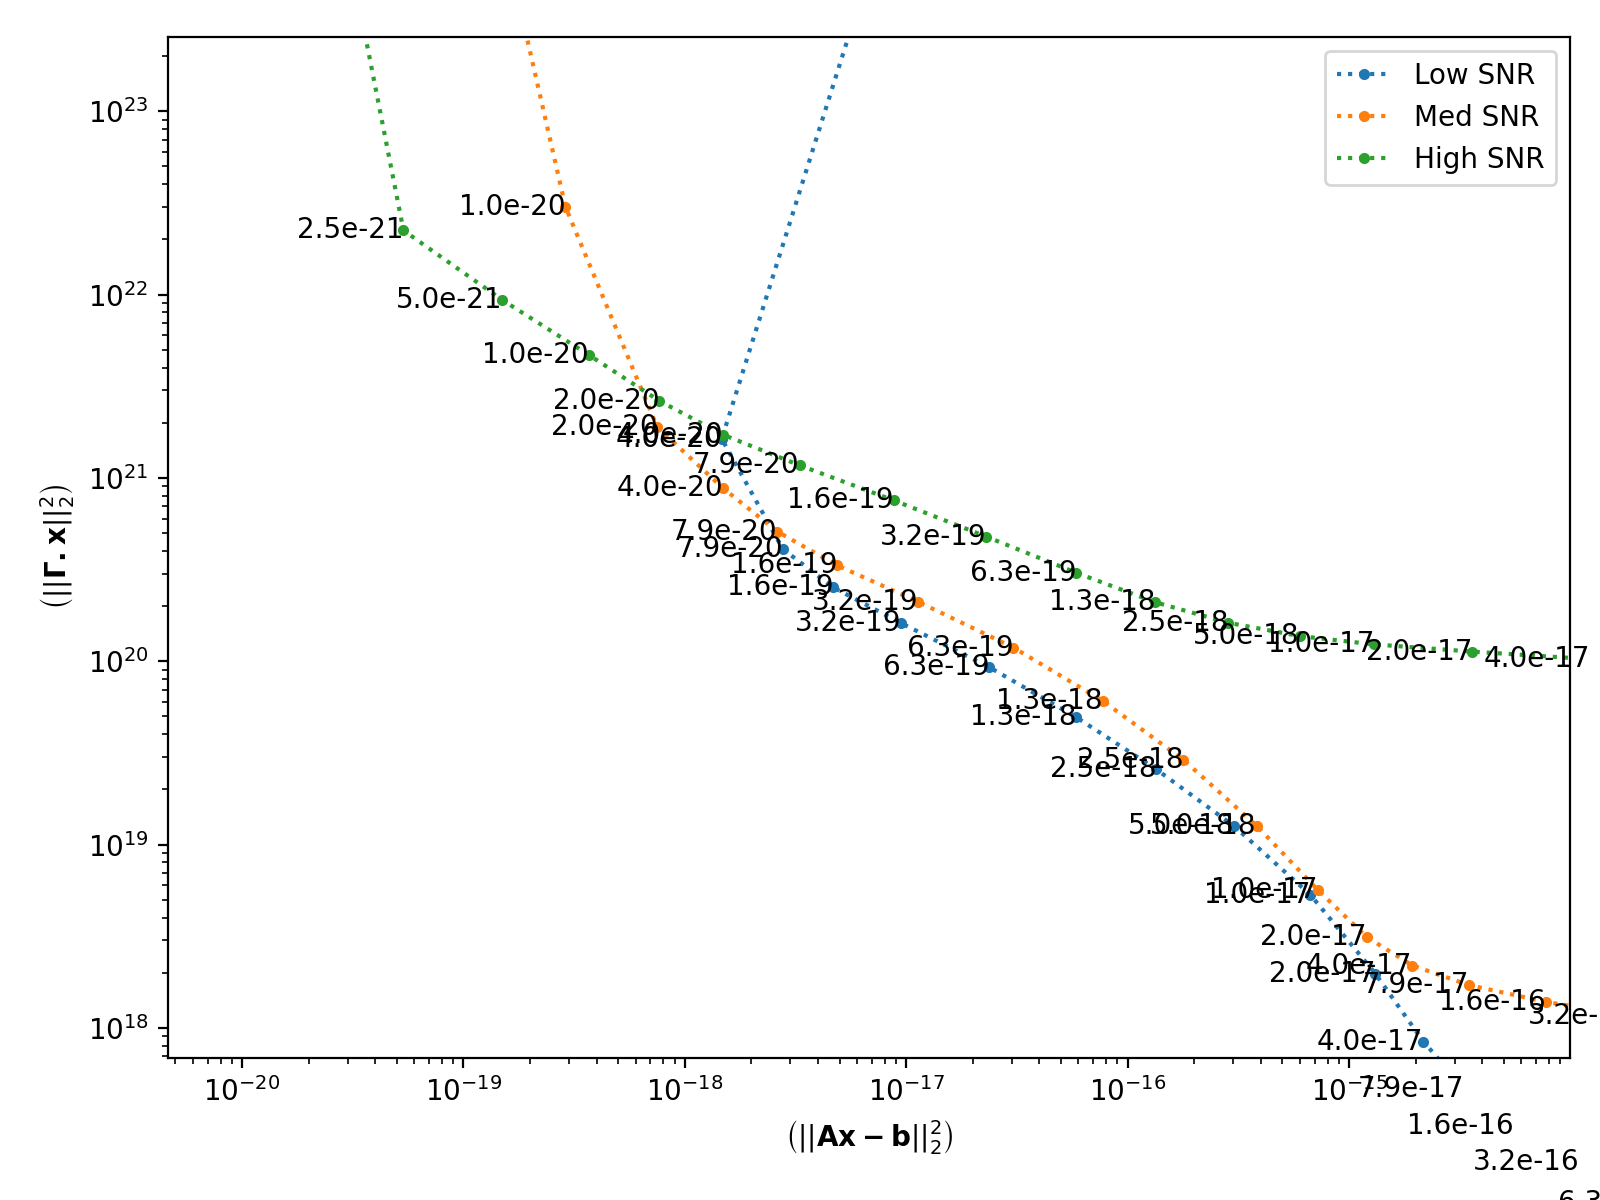

In [271]:
fig, ax = plt.subplots(figsize=(8,6))
labels = ["Low SNR", "Med SNR", "High SNR"]
for tests, label in zip(analysis_list, labels):
    tests.l_plot(ax=ax, label=label, text_label=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


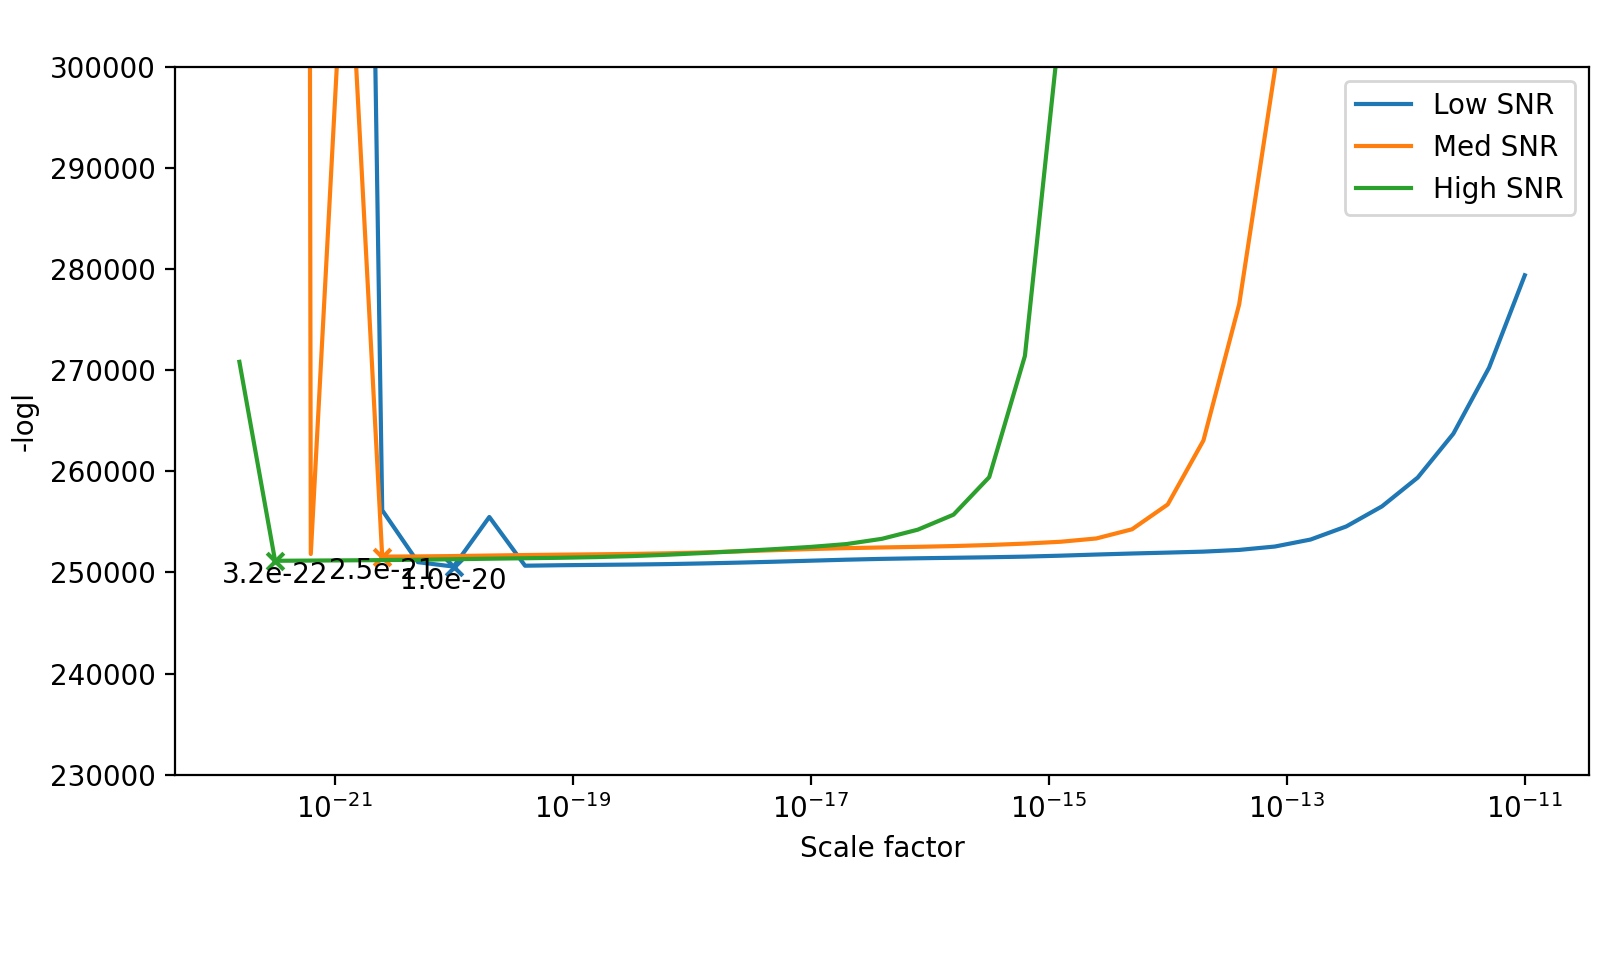

In [265]:
fig, ax = plt.subplots()
labels = ["Low SNR", "Med SNR", "High SNR"]
for tests, label in zip(analysis_list, labels):
    tests.error_plot(ax=ax, key="-logl", label=label)

ax.set_ylabel("-logl")
ax.set_yscale("linear")
plt.ylim(2.3e5, 3e5)
plt.tight_layout()